# 5-5. Clustering Documents
A cluster analysis on textual documents. One of the typical usages would be document management. Basic steps:
1. Tokenization
2. Stemming and lemmatization
3. Removing stop words and punctuation
4. Computing term frequencies or TF-IDF
5. Clustering: K-means/Hierarchical; we can then use any of the clustering algorithms to cluster different documents based on the features we have generated
6. Evaluation and visualization: Finally, the clustering results can be visualized by plotting the clusters into a two-dimensional space

In [1]:
#!pip install mpld3
import mpld3
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

  Stored in directory: C:\Users\Usuario\AppData\Local\pip\Cache\wheels\c0\47\fb\8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


### Collecting dataframe

In [7]:
# https://www.kaggle.com/subhassing/exploring-consumer-complaint-data/data
Data = pd.read_csv("large_files/Consumer_Complaints.csv",encoding='latin-1')

In [8]:
#selecting required columns and rows
Data = Data[['consumer_complaint_narrative']]
Data = Data[pd.notnull(Data['consumer_complaint_narrative'])]
Data_sample = Data.sample(200)
Data_sample[:20]

,consumer_complaint_narrative
293135,XX/XX/XXXX I took out an installment loan with...
506472,TD BANK SENT ME OUT LETTERS TELLING ME I HAD 2...
534395,To : Consumer Financial Protection On XXXX/XXX...
260042,We have been pressured by Webster to go along ...
540932,My complaint is with Prospect Mortgage XXXX Az...
277242,Someone in XXXX apparently contacted XXXX and ...
293119,"Account Resolution Services ( ARS ), used comm..."
263534,I have been in communication with american edu...
277762,I never seen these credit cards. XXXX. I never...
324902,These accounts need to be deleted because they...


### Preprocessing and TF-IDF feature engineering

In [10]:
# Remove unwanted symbol
Data_sample['consumer_complaint_narrative'] = Data_sample['consumer_complaint_narrative'].str.replace('XXXX','')
# Convert dataframe to list
complaints = Data_sample['consumer_complaint_narrative'].tolist()

# create the rank of documents – we will use it later
ranks = []
for i in range(1, len(complaints)+1):
    ranks.append(i)

In [11]:
# Stop Words
stopwords = nltk.corpus.stopwords.words('english')
# Load 'stemmer'
stemmer = SnowballStemmer("english")

In [13]:
# Functions for sentence tokenizer
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# to remove numeric tokens and raw #punctuation
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000, min_df=0.2, stop_words='english',use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [16]:
tfidf_matrix = tfidf_vectorizer.fit_transform(complaints)
terms = tfidf_vectorizer.get_feature_names()

In [15]:
tfidf_matrix.shape

(200, 31)

### Clustering using K-means

In [17]:
from sklearn.cluster import KMeans
# Define number of clusters
num_clusters = 6
#Running clustering algorithm
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
#final clusters
clusters = km.labels_.tolist()
complaints_data = { 'rank': ranks, 'complaints': complaints,'cluster': clusters }
frame = pd.DataFrame(complaints_data, index = [clusters], columns = ['rank', 'cluster'])
#number of docs per cluster
frame['cluster'].value_counts()

1    54
0    40
5    28
3    28
2    27
4    23
Name: cluster, dtype: int64

In [ ]:
# frame.groupby('cluster').count()

### Identify cluster behavior

In [21]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in complaints:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].
        values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()

Cluster 0 words: b'reporting', b'credit', b'credit', b'information', b'requested', b'account',
Cluster 1 words: b'did', b"n't", b'told', b'time', b'credit', b'asked',
Cluster 2 words: b'loan', b'service', b'payments', b'years', b'time', b'months',
Cluster 3 words: b'collection', b'number', b'phone', b'contact', b'received', b'requested',
Cluster 4 words: b'account', b'bank', b'credit', b'reporting', b'any', b'information',
Cluster 5 words: b'payments', b'months', b'account', b'time', b'told', b'pay',


C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


### Plot the clusters on a 2D graph

In [23]:
similarity_distance = 1 - cosine_similarity(tfidf_matrix)
# Convert two components as we're plotting points in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(similarity_distance) # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

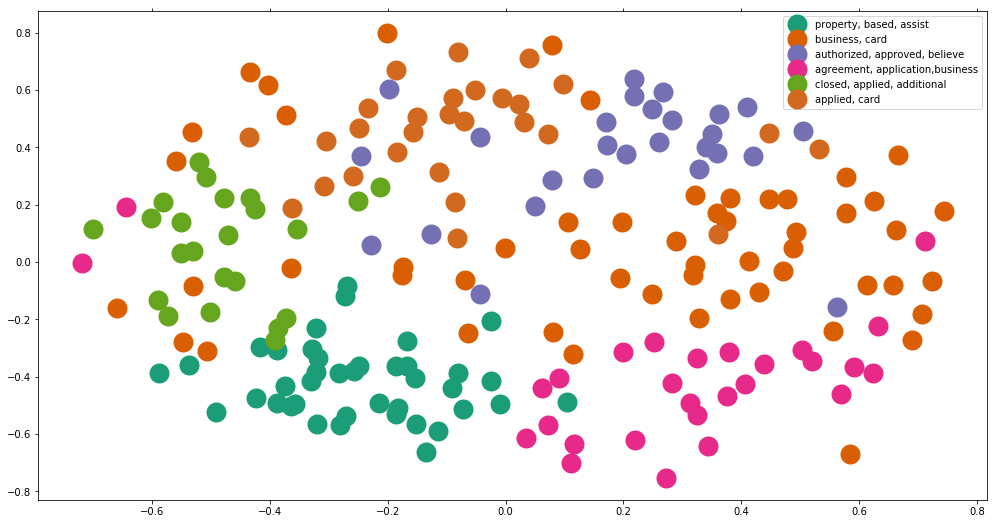

In [26]:
#Set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 
                  1: '#d95f02', 
                  2: '#7570b3', 
                  3: '#e7298a', 
                  4: '#66a61e', 
                  5: '#D2691E'}
#set up cluster names using a dict
cluster_names = {0: 'property, based, assist',
                 1: 'business, card',
                 2: 'authorized, approved, believe',
                 3: 'agreement, application,business',
                 4: 'closed, applied, additional',
                 5: 'applied, card'}
# Finally plot it
%matplotlib inline
#Create data frame that has the result of the MDS and the cluster
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
groups = df.groupby('label')
# Set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
ax.legend(numpoints=1)
plt.show()